# Python for Data Science Project: Predicting bike counts in Paris

## Introduction

Authors: Alexander Bohane - Nacer Hadni

The motivation behind this project is to predict the number of bikes passing by 'bike counters' in Paris for a given hour. These bike counters are spread over Paris and data is provided to us every hour or so over a specific time period. We will make use of this given dataset and utilise external data sources such as weather data in Paris for the required time period. Using this data we hope to accurately predict the logarithm of the bike count and will be assessed using an unseen dataset of features. The evaluation metric will be the RMSE (Root Mean Square Error)

## Data Loading and Initial Exploration

The data is presented in a .parquet format. We have access to a train and test set which we will load.

NOTE: the test and train is initially split for convenience and the combination of both is equal to the train set in the kaggle challenge. We will be assessed on `final_test.parquet`

We will thus merge `train.parquet` and `test.parquet` as one train set in our modelling and perform cross validation on the entirety of this dataset `df_all`. First let's import some preliminary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

Now we will fetch the data and merge

In [2]:
df_train = pd.read_parquet("data/train.parquet")
df_test = pd.read_parquet("data/test.parquet")

# Merge both datasets in order
df_all = pd.concat([df_train, df_test])

Let's explore the initial dataset and see what columns we are dealing with and see how many observations we have.
First, we should check for missing values

In [3]:
df_all.isna().sum()

counter_id                   0
counter_name                 0
site_id                      0
site_name                    0
bike_count                   0
date                         0
counter_installation_date    0
counter_technical_id         0
latitude                     0
longitude                    0
log_bike_count               0
dtype: int64

Luckily, there are no missing values in the dataset!

In [4]:
df_all.head(2)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147


In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496771 entries, 48321 to 929187
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496771 non-null  category      
 1   counter_name               496771 non-null  category      
 2   site_id                    496771 non-null  int64         
 3   site_name                  496771 non-null  category      
 4   bike_count                 496771 non-null  float64       
 5   date                       496771 non-null  datetime64[ns]
 6   counter_installation_date  496771 non-null  datetime64[ns]
 7   counter_technical_id       496771 non-null  category      
 8   latitude                   496771 non-null  float64       
 9   longitude                  496771 non-null  float64       
 10  log_bike_count             496771 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), int64(

In total we have 496771 observations and 11 columns including our target variable: `log_bike_count`. 
We have several numerical features that are floats and one that is in integer format:
 - bike_count
 - latitude
 - longitude
 - log_bike_count
 - site_id (int64)
 
 We also have two features that are given in datetime:
 - date
 - counter_installation_date
 
 And finally three categorical variables:
 - counter_id
 - counter_name
 - counter_technical_id

Let's now look at how the data is structured:

In [6]:
df_all.nunique()

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8973
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

### Sites and Counters

In [7]:
df_all_site_names_sorted = df_all.groupby('site_name')['counter_name'].nunique()
print(df_all_site_names_sorted.to_frame())
print(f"Total unique counter names: {df_all_site_names_sorted.sum()}")

# sort values 2-> 1

                                           counter_name
site_name                                              
152 boulevard du Montparnasse                         2
18 quai de l'Hôtel de Ville                           2
20 Avenue de Clichy                                   2
254 rue de Vaugirard                                  2
27 quai de la Tournelle                               2
28 boulevard Diderot                                  2
36 quai de Grenelle                                   2
38 rue Turbigo                                        2
39 quai François Mauriac                              2
6 rue Julia Bartet                                    2
67 boulevard Voltaire SE-NO                           1
90 Rue De Sèvres                                      2
Face 104 rue d'Aubervilliers                          2
Face au 25 quai de l'Oise                             2
Face au 4 avenue de la porte de Bagnolet              2
Face au 40 quai D'Issy                          

It looks like we have a total of 30 sites in Paris, identified by `site_name`, `counter_technical_id` and `site_id` and their respective `longitude` and `latitude`. 

By exploring further, we can see that each site is subdivided into either 1 or 2 counters identified by `counter_id` and `counter_name`. All but four sites have 2 counters they are:

- 67 boulevard Voltaire SE-NO
- Pont de la Concorde S-N
- Pont des Invalides N-S
- Pont des Invalides S-N

We can infer from the data format that every site with 2 counters contains two directions, likely because it is a two-way street: ie. a counter for one cardinal direction (example North) and a counter for the opposite cardinal direction (example south). 

For the sites with only one counter it is possible that they are simply one way streets. For 'Pont des Invalides N-S and S-N' there are two separate sites despite the same name. Perhaps this is an error and they have not been grouped together into one site, or they are two seperate one way streets but in very close proximity to each other.

### Dates and bike counts

The date appears to be structured and given by hour. Let's check the range of the data

In [8]:
print(df_all['date'].min())
print(df_all['date'].max())


2020-09-01 01:00:00
2021-09-09 23:00:00


We can see our data runs from 01/09/2020 to 09/09/2021 (European date time) which is just over a year. Next let's  check if there might be gaps in the time data

In [9]:
df_all_counter_dates = df_all.groupby('counter_name')['date'].nunique()
print((df_all_counter_dates - 8973).sort_values(ascending=True).head(10))

counter_name
254 rue de Vaugirard SO-NE          -2397
254 rue de Vaugirard NE-SO          -2397
Voie Georges Pompidou SO-NE          -455
Voie Georges Pompidou NE-SO          -455
152 boulevard du Montparnasse E-O      -6
152 boulevard du Montparnasse O-E      -6
Totem Cours la Reine E-O               -1
20 Avenue de Clichy SE-NO               0
Face au 70 quai de Bercy N-S            0
Face au 70 quai de Bercy S-N            0
Name: date, dtype: int64


There are 8973 unique datetimes over our time period corresponding to every hour between our start time and end time which is about 373 days.
 
 - Voie Georges Pompidou NE-SO and SO-NE have 455 in time data.
 - 254 rue de Vaugirard NE-SO and SO-NE have 2397 gaps in time date
 - 152 boulevard du Montparnasse E-O and O-E have 6 gaps in the data
 - Totem Cours la Reine E-O has 1 gap in the time data.
 
 
There are two possible explanations for less time data: either the counter was installed after the start time of our data (after 1st September 2020) or the counter stopped working for some amount of time. 

In [10]:
specific_counter_data_1 = df_all[df_all['counter_name'] == 'Voie Georges Pompidou SO-NE']
specific_counter_data_2 = df_all[df_all['counter_name'] == '254 rue de Vaugirard NE-SO']

# Voie Georges Pompidou installation date
print(specific_counter_data_1['counter_installation_date'].unique())

# 254 rue de Vaugirard installation date
print(specific_counter_data_2['counter_installation_date'].unique())

<DatetimeArray>
['2017-12-15 00:00:00']
Length: 1, dtype: datetime64[ns]
<DatetimeArray>
['2020-11-29 00:00:00']
Length: 1, dtype: datetime64[ns]


In [11]:
df_all.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


254 rue de Vaugirard counters were installed in the end of november 2020, which is 3 months after the start time of our data which explains the 2397 missing hours.

### Bike counts

Here we show the total bike count per counter for all sites over the whole time period to see which counter is the most frequented

In [12]:
df_count_over_all_sites = df_all.groupby(['counter_name'])['log_bike_count'].sum().sort_values(
    ascending=False)
df_count_over_all_sites

counter_name
Totem 73 boulevard de Sébastopol S-N               41419.409286
Totem 73 boulevard de Sébastopol N-S               39506.363892
Totem 64 Rue de Rivoli O-E                         38265.490779
67 boulevard Voltaire SE-NO                        36534.392600
27 quai de la Tournelle SE-NO                      35129.735285
Totem 64 Rue de Rivoli E-O                         34963.278228
Face au 48 quai de la marne SO-NE                  33877.922775
Totem Cours la Reine O-E                           33367.721185
Quai d'Orsay E-O                                   33218.873448
Face au 48 quai de la marne NE-SO                  32961.359877
Totem 85 quai d'Austerlitz SE-NO                   32891.675136
38 rue Turbigo NE-SO                               32274.777744
38 rue Turbigo SO-NE                               31982.553020
36 quai de Grenelle NE-SO                          31830.790114
27 quai de la Tournelle NO-SE                      31251.531872
Pont de la Concorde S-N    

In [13]:
# Group by 'site_name' and sum 'log_bike_count'
grouped_counts = df_all.groupby(['site_name'])['log_bike_count'].sum().reset_index()

# Merge the summed counts back into the original DataFrame
df_all = df_all.merge(grouped_counts, on='site_name', suffixes=('', '_sum_total'))


#gets rid of index

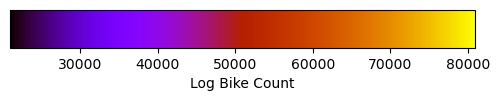

In [14]:
import matplotlib.colors as mcolors
from folium.plugins import FloatImage


min_count = df_all['log_bike_count_sum_total'].min()
max_count = df_all['log_bike_count_sum_total'].max()
norm = mcolors.Normalize(vmin=min_count, vmax=max_count, clip=True)

# Create a colormap
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gnuplot)

# Create the map
m = folium.Map(location=df_all[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

# Loop to create markers with color based on 'log_bike_count_sum'
for _, row in (
    df_all[["site_name", "latitude", "longitude", "log_bike_count_sum_total"]]
    .drop_duplicates("site_name")
    .iterrows()
):
    color = mcolors.to_hex(mapper.to_rgba(row['log_bike_count_sum_total']))
    folium.CircleMarker(
        location=row[["latitude", "longitude"]].values.tolist(), 
        popup=row["site_name"],
        radius=10,
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a colormap
cmap = plt.cm.gnuplot
norm = mcolors.Normalize(vmin=min_count, vmax=max_count)

# Create a colorbar in the figure
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
cb.set_label('Log Bike Count')


# Add the colorbar image to the map
FloatImage(cb, bottom=0, left=110).add_to(m)


# Display the map
m


We can see that the most frequented bike counters are typically clustered in the centre of paris, and as we move further away towards the outskirts of Paris, the bike count is slightly lower. There are two outliers on the lower end of the spectrum:

- Pont des Invalides N-S
- Pont des Invalides S-N

As we saw before, these two sites appear to be for the same location, we should probably group these together in our feature engineering into one site. 



Let's get a better idea of how the bike count varies with time. We can compute the average bike count for all counters at each time step and plot over a specific time period

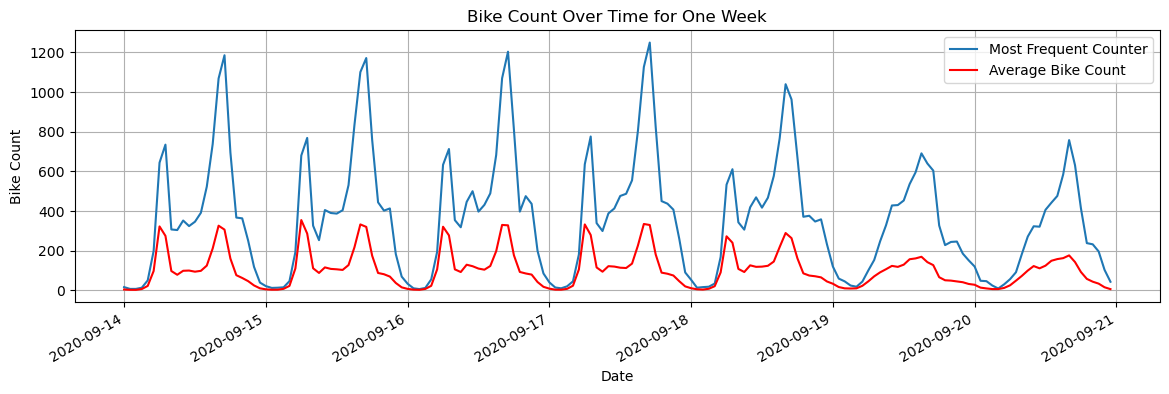

In [15]:
fig, ax = plt.subplots(figsize=(14, 4))

# Define the time frame
start_date = pd.to_datetime("2020/09/14")
end_date = pd.to_datetime("2020/09/21")

# Mask for the most frequent counter
mask_most_freq = (
    (df_all["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (df_all["date"] >= start_date)
    & (df_all["date"] < end_date)
)



# Apply the same date filter to the entire dataset for calculating the average
mask_timeframe = (df_all["date"] >= start_date) & (df_all["date"] < end_date)
average_counts = df_all[mask_timeframe].groupby('date')['bike_count'].mean()


# Plotting the data for the most frequent counter
df_all[mask_most_freq].plot(x="date", y="bike_count", ax=ax, label='Most Frequent Counter')
# Plotting the average bike_count
average_counts.plot(ax=ax, label='Average Bike Count', color='red')

# Adding legend and labels
ax.legend()
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Bike Count')
ax.set_title('Bike Count Over Time for One Week')

plt.show()

There seems to be a clear cyclical daily trend for our bike count data. Above we can see that there are generally two peaks during the day, one in the morning around 7/8 AM and one other larger peak around 4/5 PM. This is logical as it indicates people commuting to and from work.

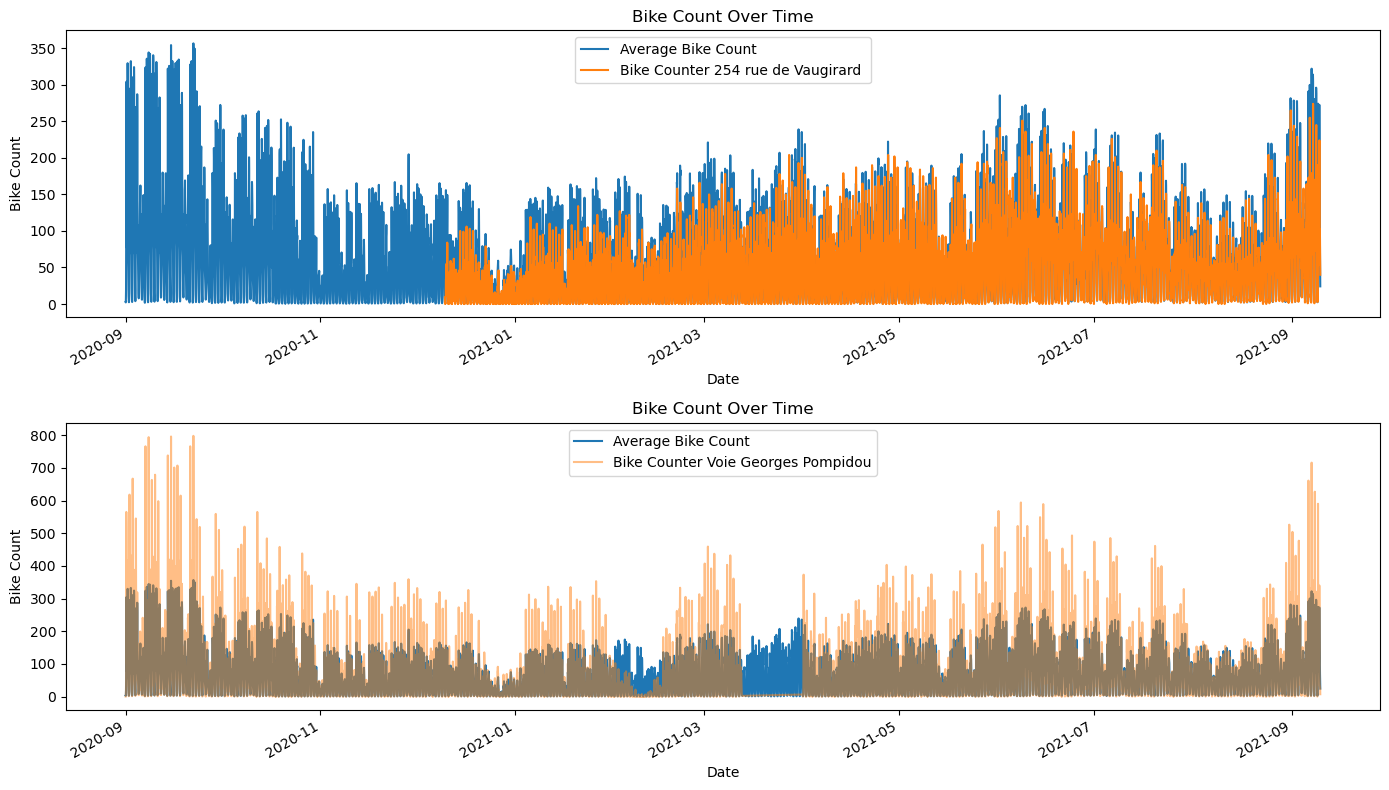

In [16]:
# Calculate average_counts
average_counts = df_all.groupby('date')['bike_count'].mean()

# Masks for the specific counters
mask_missing = df_all["counter_name"] == "254 rue de Vaugirard NE-SO"
mask_missing_two = df_all["counter_name"] == "Voie Georges Pompidou SO-NE"

# Create subplots - 2 rows, 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))  # Adjust the figure size as needed

# First graph - Average and Missing Vals Counter
average_counts.plot(ax=ax1, label='Average Bike Count')
df_all[mask_missing].plot(x="date", y="bike_count", ax=ax1, label='Bike Counter 254 rue de Vaugirard ')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel('Bike Count')
ax1.set_title('Bike Count Over Time')

# Second graph - Average and Missing Vals Counter Two
average_counts.plot(ax=ax2, label='Average Bike Count')
df_all[mask_missing_two].plot(x="date", y="bike_count", ax=ax2, label='Bike Counter Voie Georges Pompidou', alpha=0.5)

ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Bike Count')
ax2.set_title('Bike Count Over Time')

plt.tight_layout()  # Adjusts the plots to fit into the figure area.
plt.show()


In [17]:
# Ensure 'date' is the index for df_all
df_date_time = df_all.copy()
df_date_time['date'] = pd.to_datetime(df_all['date'])
df_date_time.set_index('date', inplace=True)

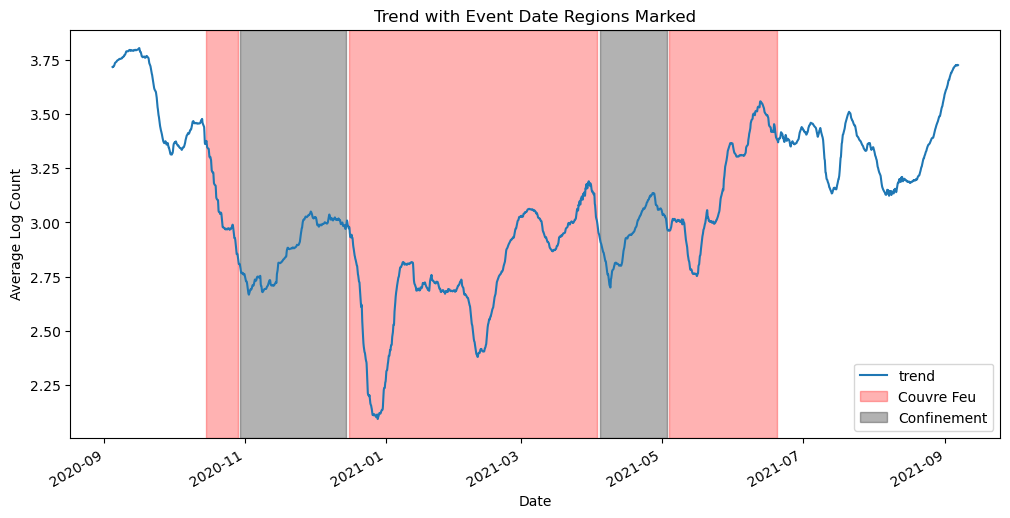

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Calculate average log counts
average_log_counts = df_date_time.groupby('date')['log_bike_count'].mean()

# You need to determine the appropriate period
# For daily data with weekly seasonality, it would be 7
# For daily data with annual seasonality, it might be 365 (or 366 for leap years), and so on
# by day 
#168
#720
#8760

period = 168
# Example: weekly seasonality in daily data

# Decompose the 'average_log_counts' time series
decomposition = seasonal_decompose(average_log_counts, model='additive', period=period)

# Extract the components
trend = decomposition.trend


plt.figure(figsize=(12, 6))
decomposition.trend.plot()

# Specify the dates of events
couvre_feu_dates = ['2020-10-15','2020-10-29','2020-12-16', '2021-4-3', '2021-5-4', '2021-6-20']
confinement_dates = ['2020-10-30', '2020-12-15', '2021-4-4', '2021-5-3']

# Shade regions for couvre feu dates
for i in range(0, len(couvre_feu_dates), 2):
    start_date = pd.to_datetime(couvre_feu_dates[i])
    end_date = pd.to_datetime(couvre_feu_dates[i + 1]) if i + 1 < len(couvre_feu_dates) else None
    plt.axvspan(start_date, end_date, color='red', alpha=0.3, label='Couvre Feu' if i == 0 else "")

# Shade regions for confinement dates
for i in range(0, len(confinement_dates), 2):
    start_date = pd.to_datetime(confinement_dates[i])
    end_date = pd.to_datetime(confinement_dates[i + 1]) if i + 1 < len(confinement_dates) else None
    plt.axvspan(start_date, end_date, color='black', alpha=0.3, label='Confinement' if i == 0 else "")

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Log Count')
plt.title('Trend with Event Date Regions Marked')

# Add the legend
plt.legend()

plt.show()

This graph shows the trend on a **daily** cyclical basis with shaded regions highlighted showing lockdowns and curfews in paris. There is clearly a trend in which less people cycled during the lockdowns and mandatory curfews. We can also see a massive dip in December which is probably due to Christmas day (and days around Christmas).

## FEATURE ENGINEERING IDEAS

- Merge Pont des Invalides N-S and S-N into one site
- Split into cardinal directions for each counter
- Split into grid showing cardinal LOCATION of each counter N, N-E, E, S-E, S, S-W, W, N-W
- Or distance measure using longitude and latitude from centre of paris so we can delete latitude and longitude in the actual model
- Add is holiday, is weekend, is weekday
- Seasonality
- Distance to every other counter (30 columns)

We want to create a feature that combines latitude and longitude to find the distance of each counter to the centre of paris. We can do this by finding the coordinates of the centre of Paris. We will choose 'La Place Dauphine' which is located right in the centre of Paris on l'Ile de la Cité. The coordinates are:

48.8565° N, 2.3426° E

We can use the euclidean distance for each counter to compute distance from centre:

$\sqrt{(LATITUDE-48.8565)^2 + (LONGITUDE-2.3426)^2}$

MORE IDEAS

- Add correction factor for COVID
- Use FFT and DFT for
- Meteo 
- Population

In [19]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X

In [20]:
def _distance_from_paris_centre(X):
    X = X.copy()  # modify a copy of X
    X.loc[:, 'distance_paris_centre'] = np.sqrt((X['latitude']-48.8565)**2 + (X['longitude']-2.3426)**2)
    
    return X.drop(columns=['latitude','longitude'])

In [21]:
from workalendar.europe import France  

def is_holiday_and_weekend(X):
    X = X.copy()
    # Initialize the France calendar from the workalendar library
    cal = France()

    # Convert 'year', 'month', 'day' to a datetime object
    X['date'] = pd.to_datetime(X[['year', 'month', 'day']])

    # Add a column for public holidays
    X['is_public_holiday'] = X['date'].apply(lambda x: cal.is_holiday(x)).astype(int)

    # Add a column for weekends
    # 5 and 6 represent Saturday and Sunday in 'weekday' column
    X['is_weekend'] = X['weekday'].apply(lambda x: x in [5, 6]).astype(int)

    return X  # Optionally dropping individual date columns



In [22]:
def add_covid_restriction_column(X):
    X = X.copy()
    X['date'] = pd.to_datetime(X[['year', 'month', 'day']])

    # Initialize the column with 'No Restriction' (0)
    X['covid_restriction'] = 0

    # Couvre feu (Curfew) dates
    couvre_feu_dates = [('2020-12-16', '2021-4-3'), 
                        ('2021-5-4', '2021-6-20')]

    # Confinement (Lockdown) dates
    confinement_dates = [('2020-10-30', '2020-12-15'), 
                         ('2021-4-4', '2021-5-3')]

    # Apply 'Curfew' (1) and 'Lockdown' (2) based on dates
    for start_date, end_date in couvre_feu_dates:
        X.loc[X['date'].between(pd.Timestamp(start_date), pd.Timestamp(end_date)), 'covid_restriction'] = 1

    for start_date, end_date in confinement_dates:
        X.loc[X['date'].between(pd.Timestamp(start_date), pd.Timestamp(end_date)), 'covid_restriction'] = 2

    return X

In [23]:
df_fe = _encode_dates(df_all)
df_fe = is_holiday_and_weekend(df_fe) 

df_fe = add_covid_restriction_column(df_fe)

df_fe = _distance_from_paris_centre(df_fe)

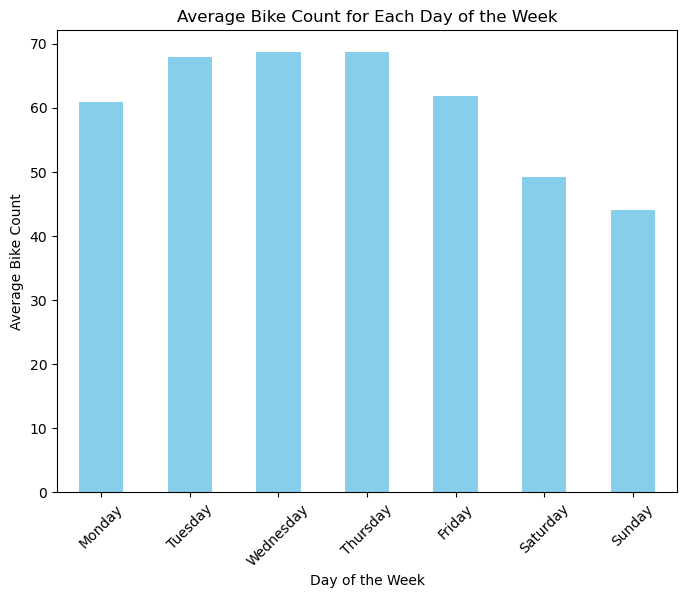

In [24]:
# Calculate the mean bike count for each day of the week
average_weekly_counts = df_fe.groupby('weekday')['bike_count'].mean()

# Mapping weekday numbers to names for clarity in the plot
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
average_weekly_counts.index = average_weekly_counts.index.map(weekday_names)

# Plotting
plt.figure(figsize=(8, 6))
average_weekly_counts.plot(kind='bar', color='skyblue')

plt.title('Average Bike Count for Each Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Bike Count')
plt.xticks(rotation=45)
plt.show()

There seems to be less people riding bikes on weekends versus weekdays, indicating that most people may be riding bikes to commute to and from work rather than for leisure.

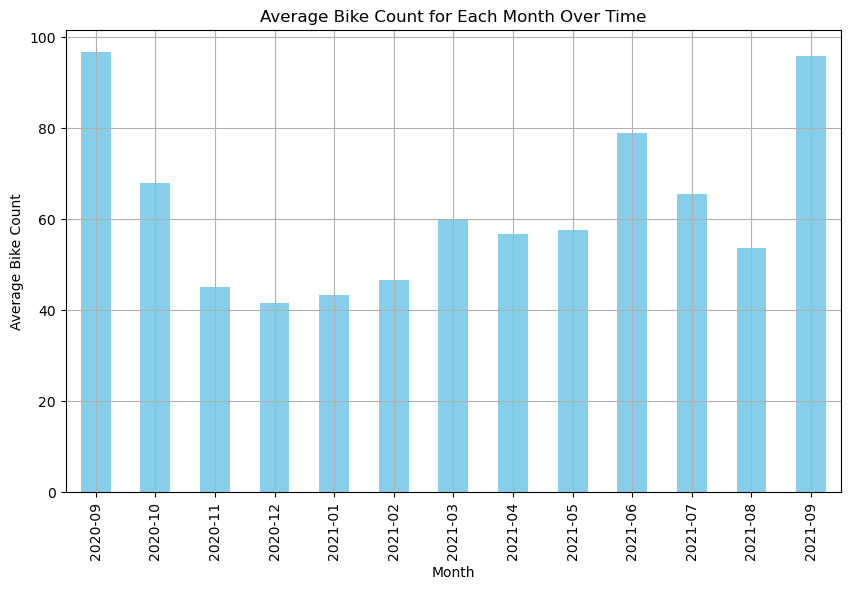

In [25]:
# Create a 'year-month' column for chronological sorting
df_fe['year_month'] = pd.to_datetime(df_fe['year'].astype(str) + '-' + df_fe['month'].astype(str))

# Calculate the mean bike count for each 'year-month'
average_monthly_counts = df_fe.groupby('year_month')['bike_count'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Average Bike Count for Each Month Over Time')
plt.xlabel('Month')
plt.ylabel('Average Bike Count')

x_labels = [date.strftime('%Y-%m') for date in average_monthly_counts.index]
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=90)


plt.grid()
plt.show()

This graph clearly shows dips in bike counts in the winter period, but also in August. This is likely because people go on holiday in August and in the holidays. The other dips could be attributed to COVID related factors but this is hard to assess as we only have data for a COVID year (and not a regular non-COVID year)

In [26]:
df_fe = df_fe.drop(['year_month'], axis=1)

In [27]:
df_fe.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,log_bike_count,log_bike_count_sum_total,year,month,day,weekday,hour,is_public_holiday,is_weekend,covid_restriction,distance_paris_centre
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01,2013-01-18,Y2H15027244,0.000000,35562.361228,2020,9,1,1,2,0,0,0,0.034459
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01,2013-01-18,Y2H15027244,0.693147,35562.361228,2020,9,1,1,3,0,0,0,0.034459
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01,2013-01-18,Y2H15027244,0.000000,35562.361228,2020,9,1,1,4,0,0,0,0.034459
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01,2013-01-18,Y2H15027244,1.609438,35562.361228,2020,9,1,1,15,0,0,0,0.034459
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01,2013-01-18,Y2H15027244,2.302585,35562.361228,2020,9,1,1,18,0,0,0,0.034459


# FE

# Modelling

In [51]:
from datetime import datetime
from workalendar.europe import France  

# Lockdown Dates
conf = [(datetime(2020, 10, 30), datetime(2020, 12, 15)), (datetime(2021, 4, 3), datetime(2021, 5, 2))]

# Curfew Dates
c_v = [(datetime(2020,10,15), datetime(2020,10,29)), (datetime(2020, 12, 16), datetime(2021, 4, 2)), (datetime(2021, 5, 3), datetime(2021, 6, 20))]

def _encode_dates(X):
    X = X.copy()  
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    return X


def is_in_range(date):
    for start, end in conf:
        if start <= date <= end:
            return 1
    for start, end in c_v:
        if start <= date <= end:
            return 1
    if date == datetime(2020, 12, 25):
        return 2
    else:
        return 0

def apply_confinement_status(X):
    X = X.copy()  # To avoid modifying the original DataFrame
    X['Confinement'] = X['date'].apply(is_in_range)
    return X

def covid_scaled_count(X):
    X = X.copy()

    # Define the COVID impact factors
    covid_impact_conf = 1.23
    covid_impact_cv = 1.16

    # Define date ranges for confinements (conf) and couvre-feu (c_v)
    conf = [(datetime(2020, 10, 30), datetime(2020, 12, 15)), (datetime(2021, 4, 3), datetime(2021, 5, 2))]
    c_v = [(datetime(2020, 10, 15), datetime(2020, 10, 29)), (datetime(2020, 12, 16), datetime(2021, 4, 2)), (datetime(2021, 5, 3), datetime(2021, 6, 20))]

    # Initialize a column for scaled bike counts
    X['scaled_bike_count'] = X['bike_count']


    # Apply the conf impact factor
    for start, end in conf:
        conf_mask = (X['date'] >= start) & (X['date'] <= end)
        X.loc[conf_mask, 'scaled_bike_count'] *= covid_impact_conf

    # Apply the c_v impact factor
    for start, end in c_v:
        cv_mask = (X['date'] >= start) & (X['date'] <= end)
        X.loc[cv_mask, 'scaled_bike_count'] *= covid_impact_cv

    return X

def covid_scaled_log_count(X):
    X = X.copy()
    # Apply ln(x+1) transformation to the scaled_bike_count
    X['scaled_log_bike_count'] = np.log1p(X['scaled_bike_count'])
    return X

def _distance_from_paris_centre(X):
    X = X.copy()  # modify a copy of X
    X.loc[:, 'distance_paris_centre'] = np.sqrt((X['latitude']-48.8565)**2 + (X['longitude']-2.3426)**2)
    
    return X
 

def is_holiday_and_weekend(X):
    X = X.copy()
    
    # Initialize the France calendar from the workalendar library
    cal = France()

    # Convert 'year', 'month', 'day' to a datetime object
    X['date'] = pd.to_datetime(X[['year', 'month', 'day']])

    # Add a column for public holidays
    X['is_public_holiday'] = X['date'].apply(lambda x: cal.is_holiday(x)).astype(int)

    # Add a column for weekends
    # 5 and 6 represent Saturday and Sunday in 'weekday' column
    X['is_weekend'] = X['weekday'].apply(lambda x: x in [5, 6]).astype(int)

    return X 

def categorize_time(X):
      # Access the 'hour' column from the DataFrame row
    
    def categorize(hour):
        if 5 <= hour < 9:
            return '5-9'
        elif 9 <= hour < 14:
            return '9-14'
        elif 14 <= hour < 21:
            return '14-21'
        elif 21 <= hour or hour < 5:
            return '21-5'
    
    X['time_category'] = X['hour'].apply(categorize)
    return X


def column_to_drop(X):

    return X.drop(['date', 'counter_installation_date',
                   'counter_technical_id','counter_id', 'site_id', 'weekday'], axis=1)


#add closest site_name or distance to closest counter

In [52]:
def combined_transformer(X):
    X = _encode_dates(X)
    X = _distance_from_paris_centre(X)
    X = is_holiday_and_weekend(X)
    X = apply_confinement_status(X)
    X = column_to_drop(X)
    X = categorize_time(X)
    print(X.info())
    return X

In [53]:
df_train = pd.read_parquet("data/train.parquet")
final_df = combined_transformer(df_train)
final_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 455163 entries, 48321 to 928462
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   counter_name           455163 non-null  category
 1   site_name              455163 non-null  category
 2   bike_count             455163 non-null  float64 
 3   latitude               455163 non-null  float64 
 4   longitude              455163 non-null  float64 
 5   log_bike_count         455163 non-null  float64 
 6   year                   455163 non-null  int32   
 7   month                  455163 non-null  int32   
 8   day                    455163 non-null  int32   
 9   hour                   455163 non-null  int32   
 10  distance_paris_centre  455163 non-null  float64 
 11  is_public_holiday      455163 non-null  int64   
 12  is_weekend             455163 non-null  int64   
 13  Confinement            455163 non-null  int64   
 14  time_category        

,counter_name,site_name,bike_count,latitude,longitude,log_bike_count,year,month,day,hour,distance_paris_centre,is_public_holiday,is_weekend,Confinement,time_category
48321,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,2020,9,1,2,0.034459,0,0,0,21-5
48324,28 boulevard Diderot E-O,28 boulevard Diderot,1.0,48.846028,2.375429,0.693147,2020,9,1,3,0.034459,0,0,0,21-5
48327,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,2020,9,1,4,0.034459,0,0,0,21-5
48330,28 boulevard Diderot E-O,28 boulevard Diderot,4.0,48.846028,2.375429,1.609438,2020,9,1,15,0.034459,0,0,0,14-21
48333,28 boulevard Diderot E-O,28 boulevard Diderot,9.0,48.846028,2.375429,2.302585,2020,9,1,18,0.034459,0,0,0,14-21


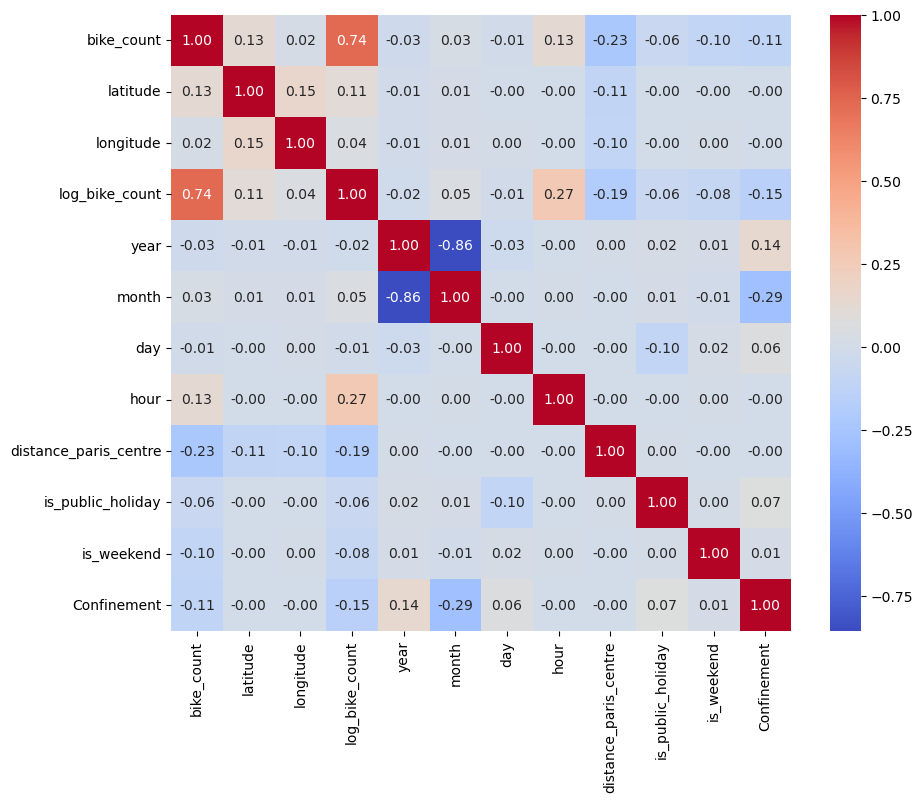

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = final_df.drop(columns=['site_name', 'counter_name', 'time_category'])

corr_matrix = corr_matrix.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.show()


In [55]:
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming 'hour', 'day', and 'month' are the column names
        for column in ['hour', 'day']:
            if column in X.columns:
                max_val = X[column].max()
                X[f'sin_{column}'] = np.sin(2 * np.pi * X[column] / max_val)
                X[f'cos_{column}'] = np.cos(2 * np.pi * X[column] / max_val)

        return X.drop(['hour','day'], axis=1)

In [73]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import TargetEncoder

def get_estimator():
    
    cyclical_encoder = CyclicalEncoder()
    
    numerical_encoder = StandardScaler()
    
    data_encoder = FunctionTransformer(combined_transformer)
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    categorical_cols = ["year", 'time_category']
    numerical_cols = ["distance_paris_centre", "latitude", 'longitude', 'rain_l_1']
    target_cols =['site_name', 'counter_name']

    preprocessor = ColumnTransformer(
        [
            ("cat", categorical_encoder, categorical_cols),  
            ('num', numerical_encoder, numerical_cols),
            ('tar', TargetEncoder(), target_cols)
        ],remainder='passthrough'
    )
    
    regressor = XGBRegressor(
    n_estimators=300, 
    max_depth=10,
    learning_rate=0.05, 
    colsample_bytree=0.5,
)

    
    pipe = make_pipeline(data_encoder, cyclical_encoder, preprocessor, regressor)
    return pipe



df_train = pd.read_parquet("data/train.parquet")
df_test = pd.read_parquet("data/test.parquet")

df_train['site_name'] = df_train['site_name'].astype(str)
df_train['site_name'] = df_train['site_name'].replace(r'^Pont des Invalides (S-N|N-S)$', 'Pont des Invalides', regex=True)
df_train['site_name'] = df_train['site_name'].astype('category')

df_test['site_name'] = df_test['site_name'].astype(str)
df_test['site_name'] = df_test['site_name'].replace(r'^Pont des Invalides (S-N|N-S)$', 'Pont des Invalides', regex=True)
df_test['site_name'] = df_test['site_name'].astype('category')


df_train = covid_scaled_count(df_train)
df_train = covid_scaled_log_count(df_train)

df_test = covid_scaled_count(df_test)
df_test = covid_scaled_log_count(df_test)

pd.to_datetime(df_train['date'])
start_date = min(df_train['date'])
end_date = max(df_train['date'])


weather = pd.read_csv("data/external_data.csv",sep='or|,+', engine='python')
weather.drop(2018, inplace=True)
weather = weather[['date','t','ff','vv','u','rr1']]

new_name = {'t' : 'Temperature' , 'ff' : 'average_wind_speed','vv' : 'horizontal_visibility','rr1' : 'rain_l_1'}

weather.rename(columns=new_name,inplace=True)
weather['rain_l_1'].bfill(inplace=True)

weather['date']=pd.to_datetime(weather['date'])
weather_train = weather[(start_date <= weather['date']) & (weather['date'] <= end_date)]
weather_train = weather_train.set_index('date')

# Sort the DataFrame by index
weather_train.sort_index(inplace=True)

# Resample to hourly and forward fill the missing values
df_hourly = weather_train.resample('H').ffill()

# Reset index to get 'date' back as a column
weather_hourly = df_hourly.reset_index().rename(columns={'index': 'date'})
df_train.reset_index(inplace=True)

df_train= pd.merge(df_train,weather_hourly,on='date' ) 
df_train.set_index('index',inplace=True)
df_train= df_train.sort_index()
df_train = df_train.drop(['average_wind_speed','u','horizontal_visibility'], axis=1)



pd.to_datetime(df_test['date'])
start_date = min(df_test['date'])
end_date = max(df_test['date'])

# Filter the DataFrame
weather_test = weather[(start_date <= weather['date']) & (weather['date'] <= end_date)]
weather_test = weather_test.set_index('date')

# Sort the DataFrame by index
weather_test.sort_index(inplace=True)

# Resample to hourly and forward fill the missing values
df_hourly = weather_test.resample('H').ffill()

# Reset index to get 'date' back as a column
weather_hourly = df_hourly.reset_index().rename(columns={'index': 'date'})
df_test.reset_index(inplace=True)

df_test = pd.merge(df_test,weather_hourly,on='date' ) 
df_test.set_index('index',inplace=True)
df_test = df_test.sort_index()
df_test = df_test.drop(['average_wind_speed','u','horizontal_visibility'], axis=1)


# Extract features and target
X_train = df_train.drop(columns=['log_bike_count', 'bike_count', 'scaled_bike_count', 'scaled_log_bike_count'])
X_train.head()

# important
y_train = df_train['scaled_log_bike_count']

pipeline = get_estimator()
pipeline.fit(X_train, y_train)

# Predict on test data
X_test = df_test.drop(columns=['log_bike_count','bike_count'])   
y_pred = pipeline.predict(X_test)
y_pred = np.maximum(y_pred, 0)

<class 'pandas.core.frame.DataFrame'>
Index: 454943 entries, 48324 to 928462
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   counter_name           454943 non-null  category
 1   site_name              454943 non-null  category
 2   latitude               454943 non-null  float64 
 3   longitude              454943 non-null  float64 
 4   Temperature            454943 non-null  float64 
 5   rain_l_1               454943 non-null  float64 
 6   year                   454943 non-null  int32   
 7   month                  454943 non-null  int32   
 8   day                    454943 non-null  int32   
 9   hour                   454943 non-null  int32   
 10  distance_paris_centre  454943 non-null  float64 
 11  is_public_holiday      454943 non-null  int64   
 12  is_weekend             454943 non-null  int64   
 13  Confinement            454943 non-null  int64   
 14  time_category        

In [74]:
def RMSE_score(y_train, y_pred):
    RMSE = np.sum(np.sqrt((y_train - y_pred)**2)/len(y_pred))
    return RMSE

y_test = df_test['log_bike_count']
RMSE = RMSE_score(y_test, y_pred)
print(f"FINAL RMSE: {RMSE}")

FINAL RMSE: 0.3523336108281252


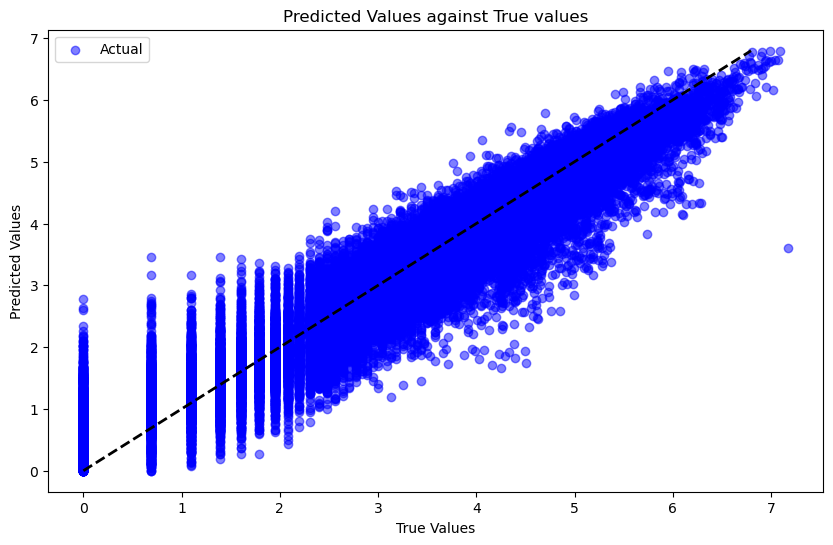

In [72]:
plt.figure(figsize=(10, 6))
plt.title('Predicted Values against True values')
plt.scatter(y_test, y_pred, label='Actual', color='blue',alpha=0.5)
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

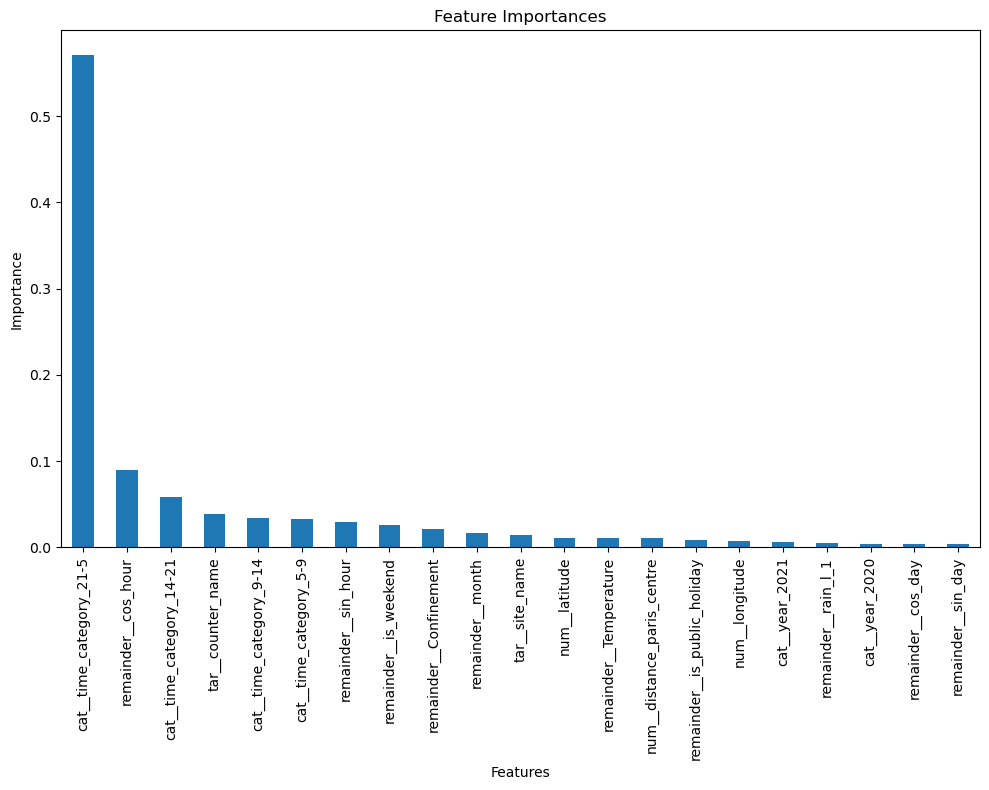

In [58]:
xgb_regressor = pipeline.named_steps['xgbregressor']

feature_importances = xgb_regressor.feature_importances_

# Get feature names from ColumnTransformer
preprocessor = pipeline.named_steps['columntransformer']
feature_names = preprocessor.get_feature_names_out()
all_features = np.array(feature_names)

# Create a pandas series to nicely display feature importances
feature_importance_series = pd.Series(feature_importances, index=all_features)

# Assuming you have your series named 'feature_importance_series'
sorted_series = feature_importance_series.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sorted_series.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust layout to fit all labels
plt.savefig('plot_name.jpg', format='jpg')
plt.show()

In [39]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [ ]:
# Define the hyperparameter grid to search
param_grid = {
    'xgbregressor__max_depth': [3, 5, 7, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__subsample': np.linspace(0.5, 1, 5),
    'xgbregressor__colsample_bytree': np.linspace(0.5, 1, 5),
    'xgbregressor__gamma': np.linspace(0, 5, 5),
    'xgbregressor__reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
    'xgbregressor__reg_lambda': [0.01, 0.1, 1, 10, 100]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

pipeline = get_estimator()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=42,
    verbose=2
)

# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

In [ ]:
# print(f"Best parameters: {best_params}")